# Neural differential equations and diffusion models tutorial in JAX

The goal of this tutorial is:

- To gain basic familiarity with JAX
- To learn how to train a simple neural differential equation (NDE)
- To learn how to train a score-based diffusion model using NDE solvers

Written by Ben Moseley (last updated: May 2024) and inspired by:
- https://docs.kidger.site/equinox/examples/score_based_diffusion/
- https://arxiv.org/abs/2001.04385

In [1]:
import gzip
import os
import struct
import urllib.request
import array

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import diffrax as dfx
import equinox as eqx
from equinox import nn
import matplotlib.pyplot as plt
import numpy as np

# Task 1: polynominal regression with JAX

The goal of this task is to gain a basic familiarity with JAX's function transforms (`vmap`, `jit`, `grad`).

We will carry out polynominal regression, using the following data:

2024-05-27 12:28:58.594842: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


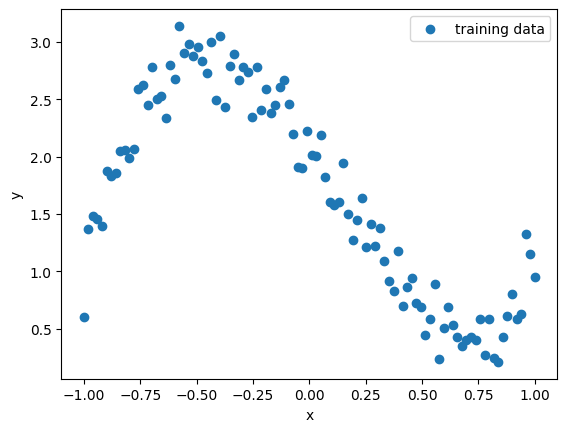

In [2]:
key = jr.key(0)
x_batch = jnp.linspace(-1, 1, 100).reshape((100,1))
y_label_batch = 3*x_batch**3 - x_batch**2 - 3*x_batch + 2 + 0.2*jax.random.normal(key, (100,1))

plt.scatter(x_batch, y_label_batch, label="training data")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()

> Task: define a `forward(theta, x)` function, which predicts `y` given a single `x` value and some learnable parameters, `theta`.

> Task: use `jax.vmap` to transform `forward` to a function which predicts a batch of `y` values given a batch of `x` values. Test that it works using `x_batch` above.

Hint: you can assume that the function is a third order polynominal, and learn its coefficients.

In [3]:
def forward(theta, x):
    "Returns model prediction, for a single example input"
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y

forward_batch = jax.vmap(forward, in_axes=(None, 0))# batched version of forward

theta = jnp.zeros(4, dtype=float)
print(forward_batch(theta, x_batch).shape)

(100, 1)


> Task: next, define a `loss(theta, x_batch, y_label_batch)` function which computes the mean-squared error of the model.

> Task: use `jax.grad` to transform `loss` into a function which computes the gradient of `loss` with respect to the model parameters, `theta`. Test that it outputs an array the same shape as `theta`.

In [4]:
def loss(theta, x_batch, y_label_batch):
    "Computes mean squared error between model prediction and training data"
    y_batch = forward_batch(theta, x_batch)
    loss = jnp.mean((y_batch-y_label_batch)**2)
    return loss

grad = jax.value_and_grad(loss, argnums=0)# gradient of loss wrt model parameters

print(grad(theta, x_batch, y_label_batch)[1])

[ 0.33085966 -0.937689    0.7706356  -3.3527174 ]


> Task: define an `step(lrate, theta, x_batch, y_label_batch)` function which carries out a single gradient descent step on `theta`, using the `grad` function you created above. It should return the updated `theta`.

> Task: use `jax.jit` to compile `step`.

In [5]:
def step(lrate, theta, x_batch, y_label_batch):
    "Performs one gradient descent step on model parameters, given training data"
    lossval, dldt = grad(theta, x_batch, y_label_batch)
    theta = jax.tree_util.tree_map(lambda t,dt: t-lrate*dt, theta, dldt)
    return theta, lossval

jit_step = jax.jit(step)# makes step go brr

> Task: finally, write a python `for` loop to train the model over 1000 gradient descent steps, with a learning rate of 0.1. You are free to choose how to initialise `theta`. Plot the results of the model.

> Task: compare the speed of training with/without `jit` compilation. How much faster is the compiled code?

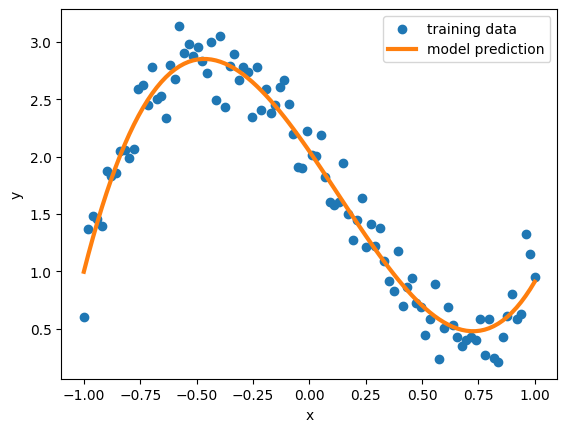

[ 2.8000598 -1.0945083 -2.84339    2.0485647]


In [6]:
# initialise theta
theta = jnp.zeros(4, dtype=float)

# run gradient descent
for i in range(1000):
    theta, lossval = jit_step(0.1, theta, x_batch, y_label_batch)

plt.scatter(x_batch, y_label_batch, label="training data")
plt.plot(x_batch, forward_batch(theta, x_batch), color="tab:orange", lw=3, label="model prediction")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()
print(theta)

In [7]:
%timeit jit_step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()
%timeit step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()

141 µs ± 849 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
11.5 ms ± 686 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Task 2: Neural differential equations with JAX

In this task we will learn unknown dynamics in the Lotka-Volterra model.

The Lotka-Volterra model is given by:
$$
\begin{align}
\frac{dx}{dt}&=\alpha x - \beta x y \\
\frac{dy}{dt}&=\gamma x y - \delta y
\end{align}
$$
where
- $x=$ population density of prey 
- $y=$ population density of predator 
- $\alpha, \beta=$ max prey birth rate, effect of predators on prey growth rate
- $\delta, \gamma=$ max predator death rate, effect of prey on predator growth rate

> Task: write a function `f(x, *fargs)` which computes the RHS of the ODE ($\mathbf{f}=(\dot x, \dot y)$), given a set of coefficients `fargs`$=(\alpha, \beta, \gamma, \delta)$ and the current state $\mathbf{x} = (x, y)$.

> Task: given some initial prey and predator population, $\mathbf{x}_0=(x_0,y_0)$, write a generic `ode_solver(x0, N, dt, f, fargs)` function which solves the system numerically from $t=0$ to $t=T=N\Delta t$ using $N$ timesteps with a time interval of $\Delta t$. The solver should return $X = (\mathbf{x}_0, \mathbf{x}_1,..., \mathbf{x}_T)$ as an array of shape $(N+1, 2)$.

> Task: check the solver works by plotting the solution $X$ given the initial populations, coefficients and hyperparameters listed below.

Hint: use the 4th order explicit Runge-Kutta method to solve the ODE. The update step for this method is given by:

$$
\begin{align}
\mathbf{x}_{t+1} &= \mathbf{x}_t + \frac{\Delta t}{6}(\mathbf{k}_1 + 2\mathbf{k}_2 + 2\mathbf{k}_3 + \mathbf{k}_4)
\end{align}
$$

$$
\begin{align}
\mathbf{k}_1 &= \mathbf{f}(\mathbf{x}_t) \\
\mathbf{k}_2 &= \mathbf{f}\left(\mathbf{x}_t + \frac{\Delta t \mathbf{k}_1}{2}\right) \\
\mathbf{k}_3 &= \mathbf{f}\left(\mathbf{x}_t + \frac{\Delta t \mathbf{k}_2}{2}\right) \\
\mathbf{k}_4 &= \mathbf{f}(\mathbf{x}_t + \Delta t \mathbf{k}_3)
\end{align}
$$

>Task: use `jax.lax.scan` to implement the `for` loop of the ODE solver. This will significantly increase compilation speed later on.

(501, 2)


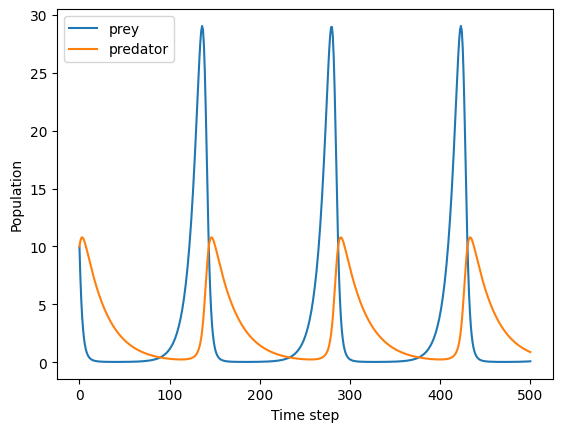

In [8]:
def f(x, alpha, beta, gamma, delta):
    "Computes RHS of Lotka-Volterra ODE"
    x, y = alpha*x[0:1]-beta*x[0:1]*x[1:2], gamma*x[0:1]*x[1:2]-delta*x[1:2]
    f = jnp.concatenate([x,y], axis=0)
    return f

def ode_solver(x0, N, dt, f, fargs):
    "Generic 4th order explicit RK ODE solver. f(x, *fargs) is a function which computes the RHS of the ODE."
    
    def single_step(x, i):
        k1 = f(x, *fargs)
        k2 = f(x+dt*k1/2, *fargs)
        k3 = f(x+dt*k2/2, *fargs)
        k4 = f(x+dt*k3, *fargs)
        x = x + (dt/6)*(k1+2*k2+2*k3+k4)
        return x, x
        
    _, X = jax.lax.scan(single_step, x0, jnp.arange(N))
    X = jnp.concatenate([x0.reshape((1,-1)), X], axis=0)
    
    return X

# solve LV system
x0 = jnp.array([10.,10.])
N = 500
dt = 0.1
fargs = (1.1, 0.4, 0.1, 0.4)# alpha, beta, gamma, delta
X = ode_solver(x0, N, dt, f, fargs)
print(X.shape)

# plot solution
def plot_solution(X, scatter=False, show=True):
    plt.figure()
    if scatter:
        plt.scatter(jnp.arange(X.shape[0]), X[:,0], alpha=0.8, label="prey")
        plt.scatter(jnp.arange(X.shape[0]), X[:,1], alpha=0.8, label="predator")
    else:
        plt.plot(X[:,0], label="prey")
        plt.plot(X[:,1], label="predator")
    plt.ylabel("Population")
    plt.xlabel("Time step")
    plt.legend()
    if show:
        plt.show()
plot_solution(X)

Next, we will assume that some of the terms in the ODE are unknown, and we will learn them. In particular, we will assume that

$$
\begin{align}
\frac{dx}{dt}&= N\!N(x;\mathbf{\theta}_1) - \beta x y \\
\frac{dy}{dt}&=\gamma x y - \theta_2 y
\end{align}
$$

where $N\!N(x;\mathbf{\theta}_1)$ is a neural network and $\theta_2$ is a learnable coefficient. We will assume we know that  $\beta=0.2$, $\gamma=0.1$. We will train both the network and $\theta_2$ using the following observations of the population dynamics from some unknown ODE (note: it's not the same ODE we solved above!):

(200, 2)


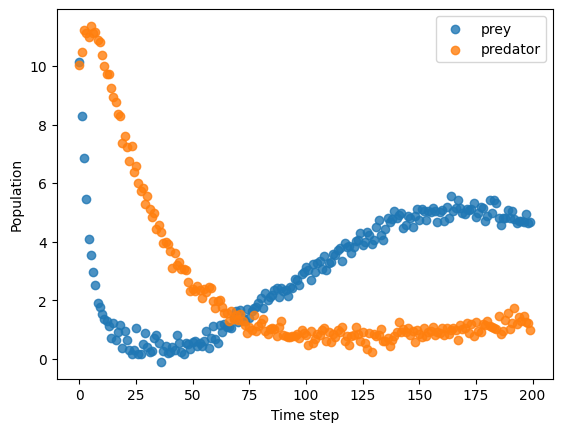

In [9]:
def f_true(x):
    "Computes RHS of Lotka-Volterra ODE"
    x, y = jax.nn.tanh(x[0:1])-0.2*x[0:1]*x[1:2], 0.1*x[0:1]*x[1:2]-0.4*x[1:2]
    f = jnp.concatenate([x,y], axis=0)
    return f
_s = ode_solver(x0=jnp.array([10.,10.]), N=199, dt=0.1, f=f_true, fargs=())
np.save("X_obs.npy", _s+0.2*jr.normal(jr.key(0),_s[:200].shape))
del _s

X_obs = jnp.array(np.load("X_obs.npy"))
print(X_obs.shape)
plot_solution(X_obs, scatter=True)

To learn the network and coeffficient, we first need to define the neural network in JAX.

> Task: use the `equinox` library to define a fully connected network with 1 hidden layer and `tanh` activation functions. The network should take $x$ as input and output a single scalar value (corresponding to the unknown term above).

Hint: the equinox API is designed to be analogous to the PyTorch API - neural network classes are defined in a similar way. See here for help: https://docs.kidger.site/equinox/examples/mnist/#the-model

In [10]:
class FCN(eqx.Module):
    "Fully-connected neural network, with 1 hidden layer"
    
    input_layer: nn.Linear
    hidden_layer: nn.Linear
    output_layer: nn.Linear

    def __init__(self, in_size, hidden_size, out_size, key):
        "Initialise network parameters"
        
        key1, key2, key3 = jr.split(key, 3)
        self.input_layer = nn.Linear(in_size, hidden_size, key=key1)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size, key=key2)
        self.output_layer = nn.Linear(hidden_size, out_size, key=key3)

    def __call__(self, x):
        "Defines forward model"
        
        x = (x/10)-0.5# normalise input to expected range (given observational data)
        x = jax.nn.tanh(self.input_layer(x))
        x = jax.nn.tanh(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

# create a network with 32 hidden units
key = jr.key(0)
model = FCN(1,32,1,key)
print(model)

FCN(
  input_layer=Linear(
    weight=f32[32,1],
    bias=f32[32],
    in_features=1,
    out_features=32,
    use_bias=True
  ),
  hidden_layer=Linear(
    weight=f32[32,32],
    bias=f32[32],
    in_features=32,
    out_features=32,
    use_bias=True
  ),
  output_layer=Linear(
    weight=f32[1,32],
    bias=f32[1],
    in_features=32,
    out_features=1,
    use_bias=True
  )
)


Next we need to define a new function which computes the RHS of the NDE, which we will pass to `ode_solver`.

> Task: write a new `f(x, *fargs)` function that computes the RHS of the NDE above, where `fargs=(model, theta2)`.

Note: $\beta=0.2$, $\gamma=0.1$ should now be hard-coded in the function, and not passed as arguments.

In [11]:
def f(x, model, theta2):
    "Computes RHS of Lotka-Volterra NDE"
    x, y = model(x[0:1])-0.2*x[0:1]*x[1:2], 0.1*x[0:1]*x[1:2]-theta2*x[1:2]
    f = jnp.concatenate([x,y], axis=0)
    return f

Now we need to write a loss function to train the NDE. We will solve the NDE using `ode_solver` and `f`, and match the output solution to the observed data.

> Task: write a loss function which computes the mean-squared-error between the solution of the NDE and the observed data, `X_obs`.

Note: the observational data was created with `x0 = jnp.array([10.,10.])`, `dt = 0.1`, `N = 199`.

> Task: using an untrained network and $\theta_2 = 0$, check that your loss function outputs a scalar value, and plot the NDE solution.

72.24376


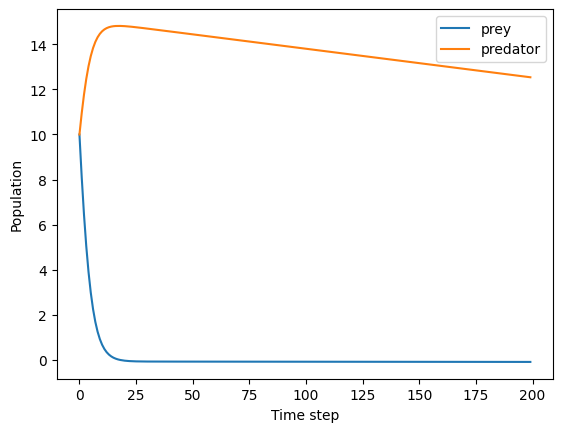

In [12]:
def loss(x0, N, dt, f, fargs, X_obs):
    "Computes mean squared error between NDE solution and observed data"
    X = ode_solver(x0, N, dt, f, fargs)
    loss = jnp.mean((X-X_obs)**2)
    return loss

# solve untrained NDE
x0 = jnp.array([10.,10.])
N = 199
dt = 0.1
fargs = (model, jnp.array(0.0))
print(loss(x0, N, dt, f, fargs, X_obs))
X = ode_solver(x0, N, dt, f, fargs)
plot_solution(X)

Finally, we a ready to train the NDE.

> Task: use the training code below to train the NDE. 

> Task: plot the trained solution of the NDE and compare it to the observational data.

Make sure you understand how the code works: it just implements a standard gradient descent loop using the `optax` library.

[1/2000] loss: 72.24375915527344


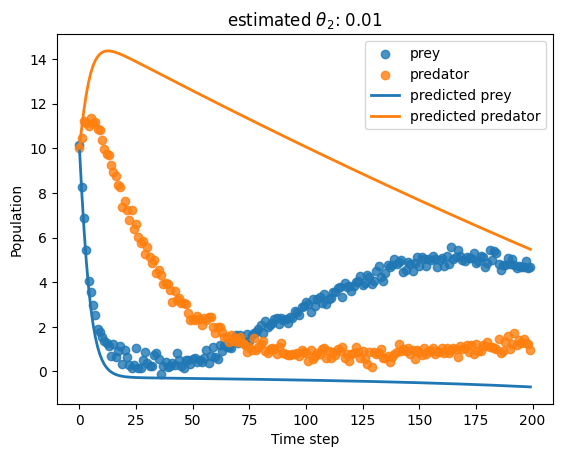

[500/2000] loss: 0.05756980925798416


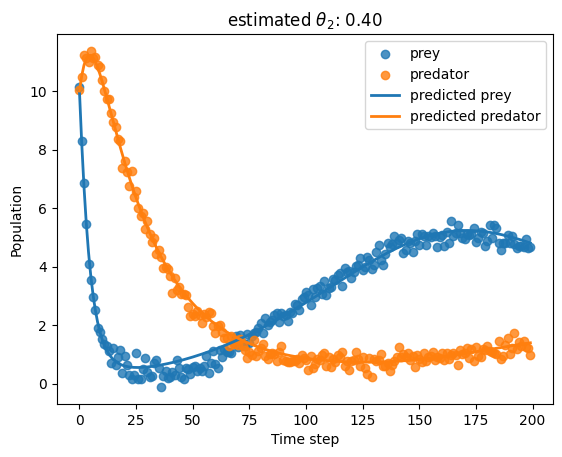

[1000/2000] loss: 0.04358096048235893


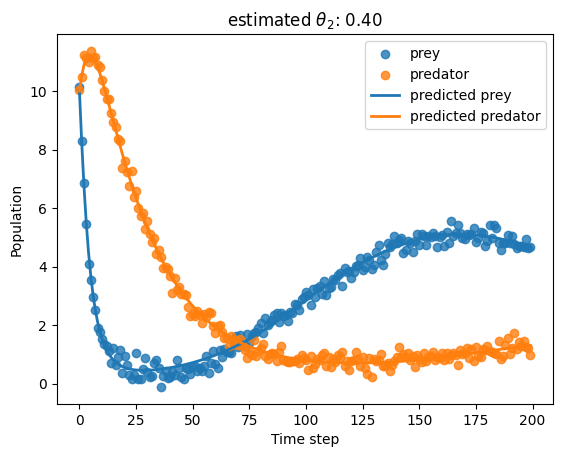

[1500/2000] loss: 0.04196283221244812


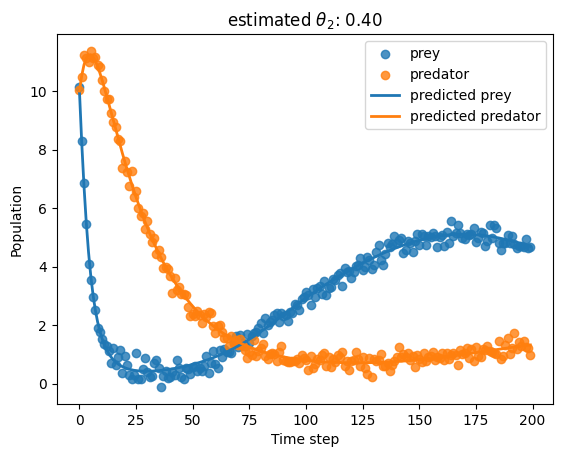

[2000/2000] loss: 0.04127135127782822


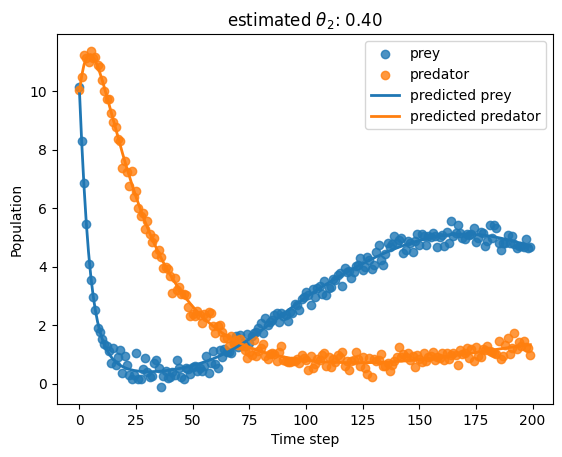

In [13]:
def grad(x0, N, dt, f, fargs, X_obs):
    "Computes gradient of loss function wrt fargs"
    partial = lambda fargs: loss(x0, N, dt, f, fargs, X_obs)
    return eqx.filter_value_and_grad(partial)(fargs)

@eqx.filter_jit
def step(x0, N, dt, f, fargs, X_obs, opt_state, opt_update):
    "Performs one gradient descent step on fargs"
    lossval, grads = grad(x0, N, dt, f, fargs, X_obs)
    updates, opt_state = opt_update(grads, opt_state)
    fargs = eqx.apply_updates(fargs, updates)
    return lossval, fargs, opt_state

x0 = jnp.array([10.,10.])
N = 199
dt = 0.1

# initialise learnable parts
key = jr.key(0)
model = FCN(1,32,1,key)
fargs = (model, jnp.array(0.0))

# define optimiser
optimiser = optax.adam(learning_rate=1e-2)
opt_state = optimiser.init(eqx.filter(fargs, eqx.is_array))
opt_update = optimiser.update
n_steps = 2000

# train NDE
lossvals = []
for i in range(n_steps):
    lossval, fargs, opt_state = step(x0, N, dt, f, fargs, X_obs, opt_state, opt_update)
    lossvals.append(lossval)
    if (i+1)%500==0 or i==0:
        print(f"[{i+1}/{n_steps}] loss: {lossval}")
        
        # plot result
        X = ode_solver(x0, N, dt, f, fargs)
        plot_solution(X_obs, scatter=True, show=False)
        plt.plot(X[:,0], lw=2, label="predicted prey")
        plt.plot(X[:,1], lw=2, label="predicted predator")
        plt.legend()
        plt.title(f"estimated $\\theta_2$: {fargs[1]:.2f}")
        plt.show()

> Task: finally, plot $N\!N(x;\mathbf{\theta}_1)$, over the range $x \in [0.5,6]$. Can you guess what the mathematical expression for this function is?

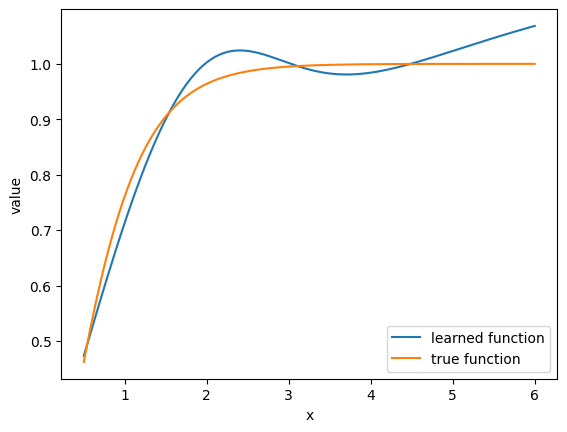

In [14]:
x = jnp.linspace(0.5,6,1000).reshape(-1,1)
plt.figure()
plt.plot(x, jax.vmap(lambda x: fargs[0](x))(x), label="learned function")
plt.plot(x, jax.nn.tanh(x), label="true function")
plt.legend()
plt.xlabel("x")
plt.ylabel("value")
plt.show()

# Task 3: Score-based diffusion model with JAX

In this task we will train a score-based diffusion model to generate images of handwritten digits, using MNIST as training data.

That is, we will learn to reverse-diffuse a random sample from a prior distribution, $p_T(\mathbf{x})$ (in this case a multivariate Gaussian with i.i.d. variables), into a random sample from $p_0(\mathbf{x})$, the distribution defining all possible MNIST images, where $\mathbf{x}$ is a matrix of pixel values.

First, we will load our training data:

(60000, 1, 28, 28)


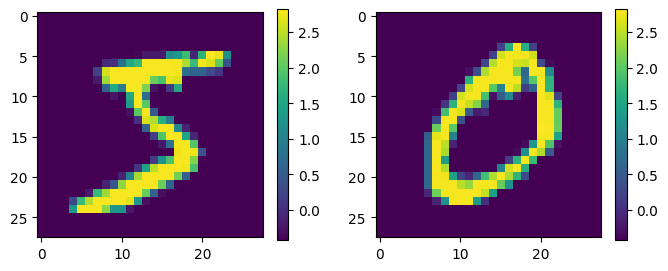

In [15]:
def mnist():
    "Downloads and loads MNIST dataset"
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)
            
data = mnist()
data = (data - jnp.mean(data)) / jnp.std(data)# normalise
print(data.shape)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(data[0,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(data[1,0])
plt.colorbar()
plt.show()

We will sample from $p_0(\mathbf{x})$ by solving the probability flow ODE in reverse. For a forward SDE which diffuses $\mathbf{x}_0 \sim p_0(\mathbf{x})$ to $\mathbf{x}_T \sim p_T(\mathbf{x})$, given by 

$$
d\mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w}
$$

The probability flow ODE is given by

$$
\frac{d\mathbf{x}}{dt} = \mathbf{f}(\mathbf{x},t) - \frac{1}{2} g(t)^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x})
$$


When solved in reverse (from $t=T$ to $t=0$) using $\mathbf{x}_T \sim p_T(\mathbf{x})$, the solution is a sample $\mathbf{x}_0 \sim p_0(\mathbf{x})$.

We assume the underlying forward diffusion model is governed by the "variance preserving" SDE, given by

$$
d\mathbf{x} = -\frac{1}{2}\beta(t)\mathbf{x} dt + \sqrt{\beta(t)} d\mathbf{w}
$$

In this case the probability flow ODE is given by

$$
\frac{d\mathbf{x}}{dt} = -\frac{1}{2}\beta(t)\mathbf{x} - \frac{1}{2}\beta(t) \nabla_{\mathbf{x}} \log p_t(\mathbf{x})
$$

Training the diffusion model amounts to learning the score function with a neural network, i.e. $\mathbf{s}(\mathbf{x}, t;\mathbf{\theta})\approx \nabla_{\mathbf{x}} \log p_t(\mathbf{x})$

Once we have trained the neural network, we can solve the following NDE to sample from $p_0(\mathbf{x})$:

$$
\frac{d\mathbf{x}}{dt} = -\frac{1}{2}\beta(t)\mathbf{x} - \frac{1}{2}\beta(t) \mathbf{s}(\mathbf{x}, t;\mathbf{\theta})
$$

First, we need to define the neural network we will use to approximate the score function. In this example we use a U-Net. 

Note, the network should take $\mathbf{x}$ and $t$ as input and output a tensor the same shape as $\mathbf{x}$. To input $t$, we simply add it as an extra input channel by repeating and concatenating it to $\mathbf{x}$.

In [16]:
def relu_layer(x, key=None):
    return jax.nn.relu(x)

class UNet(eqx.Module):
    down_conv_blocks: list
    max_pools: list
    conv_transposes: list
    up_conv_blocks: list
    conv_final: nn.Conv2d
    n_levels: int
        
    def __init__(self, in_channels, out_channels, n_hidden, n_levels, n_width, key):
        
        key1,key2,key3,key4 = jr.split(key, 4)
        self.n_levels = n_levels
        
        # downsampling and middle convolutional blocks
        self.down_conv_blocks = [
            nn.Sequential(
                ([nn.Conv2d(n_hidden*(2**(il-1)) if il!=0 else in_channels, n_hidden*(2**(il)), kernel_size=3, stride=1, padding=1, key=key1)]+
                  [relu_layer]+
                  ([nn.Sequential(
                    ([nn.Conv2d(n_hidden*(2**(il)), n_hidden*(2**(il)), kernel_size=3, stride=1, padding=1, key=key2)]+
                      [relu_layer])
                    ) for key1,key2 in jr.split(key, (n_width, 2))])
                  )
                )
            for il,key in enumerate(jr.split(key1, n_levels+1))]
        
        # pooling operations
        self.max_pools = [
                nn.MaxPool2d(kernel_size=2, stride=2)
            for il in range(n_levels)]
        
        # transposed convolutions
        self.conv_transposes = [
                nn.ConvTranspose2d(n_hidden*(2**(n_levels-il)), n_hidden*(2**(n_levels-il-1)), kernel_size=2, stride=2, key=key)
            for il,key in enumerate(jr.split(key2, n_levels))]
        
        # upsampling convolutional blocks
        self.up_conv_blocks = [
            nn.Sequential(
                ([nn.Conv2d(n_hidden*(2**(n_levels-il)), n_hidden*(2**(n_levels-il-1)), kernel_size=3, stride=1, padding=1, key=key1)]+
                  [relu_layer]+
                  ([nn.Sequential(
                    ([nn.Conv2d(n_hidden*(2**(n_levels-il-1)), n_hidden*(2**(n_levels-il-1)), kernel_size=3, stride=1, padding=1, key=key2)]+
                      [relu_layer])
                    ) for key1,key2 in jr.split(key, (n_width, 2))])
                  )
                )
            for il,key in enumerate(jr.split(key3, n_levels))]
        
        self.conv_final = nn.Conv2d(n_hidden, out_channels, kernel_size=1, stride=1, key=key4)
        
    def __call__(self, x, t, t1):
        print(x.shape, t.shape)
        x = jnp.concatenate([x,jnp.tile(t/t1,x.shape)], axis=0)# simply add time as an extra channel
        print(x.shape)
        
        # downsampling blocks
        skips = []
        for il in range(self.n_levels):
            x = self.down_conv_blocks[il](x)
            skips.append(x)
            x = self.max_pools[il](x)
            print(x.shape)
        
        # middle block
        x = self.down_conv_blocks[-1](x)
        print(x.shape)
        
        # upsampling blocks
        for il in range(self.n_levels):
            x = self.conv_transposes[il](x)
            x = jnp.concatenate([x, skips[self.n_levels-il-1]], axis=0)
            x = self.up_conv_blocks[il](x)
            print(x.shape)
        
        x = self.conv_final(x)
        print(x.shape)
        
        return x

Next, we need to define the loss function to train the network. In general, this is usually given by

$$
\mathcal{L}(\theta) = \mathbb{E}_{t, \mathbf{x}_0 \sim p_0, \mathbf{x}_t \sim p_{t|0}(\mathbf{x}_t | \mathbf{x}_0)} \left[ \lambda(t) \left\| \mathbf{s}(\mathbf{x}_t, t;\mathbf{\theta}) - \nabla_{\mathbf{x}_t} \log p_{t|0}(\mathbf{x}_t | \mathbf{x}_0) \right\|^2 \right]
$$

With the weighting factor, $\lambda(t)$, given by

$$
\lambda(t) = \mathbb{E}\left[ \left\| \nabla_{\mathbf{x}_t} \log p_{t|0}(\mathbf{x}_t | \mathbf{x}_0) \right\|^2 \right]
$$

For the variance-preserving SDE, it can be shown that the transition probability is a Gaussian distribution

$$
p_{t|0}(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \mathbf{x}_0 e^{-\frac{1}{2} \int_0^t \beta(t) dt}, 1-e^{-\int_0^t \beta(t) dt} I)
$$

> Task: show that in this case, the loss can be written as:

$$
\mathcal{L}(\theta) = \mathbb{E}_{t, \mathbf{x}_0 \sim p_0, \mathbf{z} \sim \mathcal{N}(\cdot;0,I)} \left[ \sigma^2 \left\| \mathbf{s}(\mu \mathbf{x}_0 + \sigma\,\mathbf{z}, t;\mathbf{\theta}) + \frac{\mathbf{z}}{\sigma} \right\|^2 \right]
$$

With $\mu=e^{-\frac{1}{2} \int_0^t \beta(t) dt}$, $\sigma^2 = 1-e^{-\int_0^t \beta(t) dt}$.

> Task: write a `loss(model, int_beta, t1, x_0, t, key)` function which computes this loss function for a single sample of `x_0` and `t`.

Note: assume `int_beta(t)` is a function which outputs the value of the integral $\int_0^t \beta(t) dt$ for you.

In [17]:
def loss(model, int_beta, t1, x_0, t, key):
    "Loss value for a single x_0"
    
    # mean and variance of p(x_t|x_0)
    mean = x_0 * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)# for numerical stability
    std = jnp.sqrt(var)
    
    # sample x_t from p(x_t|x_0)
    noise = jr.normal(key, x_0.shape)
    x_t = mean + std * noise
    
    # compute predicted score
    score = model(x_t, t, t1)
    
    # compute grad log p(x_t|x_0)
    glp = - noise / std
    
    # compute loss
    loss = var * jnp.mean((score - glp)**2)
    
    return loss

def loss_batch(model, int_beta, t1, x_0_batch, key):
    "Compute loss over batch of x_0, using random t for each example"
    
    batch_size = x_0_batch.shape[0]
    key, subkey = jr.split(key)
    
    # sample t values with low-discrepancy
    t_batch = jr.uniform(subkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t_batch = t_batch + (t1 / batch_size) * jnp.arange(batch_size)
    
    # evaluate losses
    key_batch = jr.split(key, batch_size)
    loss_batch = jax.vmap(loss, in_axes=(
        None, None, None, 0,0,0))(
        model, int_beta, t1, x_0_batch, t_batch, key_batch)

    return jnp.mean(loss_batch)

@eqx.filter_jit
def make_step(model, int_beta, t1, x_0_batch, opt_state, opt_update, key):
    "Carries out a gradient descent step to train score model"
    
    grad = eqx.filter_value_and_grad(loss_batch)
    lossval, grads = grad(model, int_beta, t1, x_0_batch, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return lossval, model, opt_state

> Task: write the `single_sample_fn` function below, which should randomly sample $\mathbf{x}_T$ and solve the ODE in reverse from $t=T=$ `t1` to $t=0$, with a timestep of `dt0`.

Hint: you can compute beta using `beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))`

Hint: use `diffrax` to solve the ODE, using the `dfx.Tsit5` solver. See here for help: https://docs.kidger.site/diffrax/#quick-example

In [18]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, t1, x_0_shape, dt0, key):
    "Sample diffusion model (solve NDE backwards in time)"
    
    def f(t, x, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (x + model(x, jnp.array(t), t1))

    term = dfx.ODETerm(f)
    solver = dfx.Tsit5()
    x_1 = jr.normal(key, x_0_shape)
    sol = dfx.diffeqsolve(term, solver, t1, 0, -dt0, x_1)
    x_0 = sol.ys[0]
    return x_0

Finally, we can train the model.

> Task: run the code below to train the diffusion model.

Note: training takes a few minutes on a GPU (and longer on a CPU).

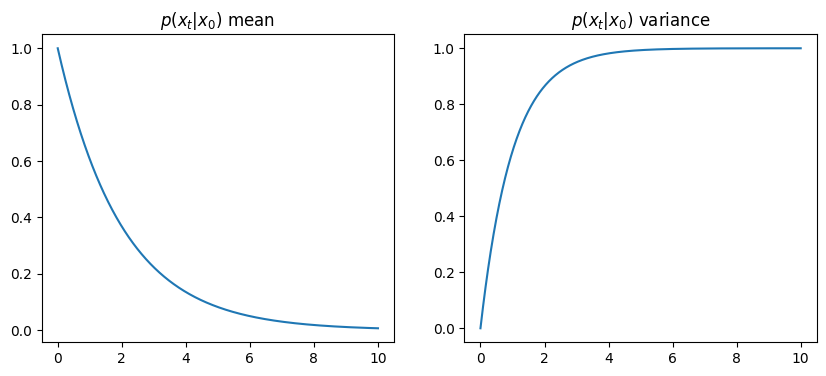

(1, 28, 28) ()
(2, 28, 28)
(32, 14, 14)
(64, 7, 7)
(128, 7, 7)
(64, 14, 14)
(32, 28, 28)
(1, 28, 28)
[1/50000] loss: 1.0049992799758911
[2000/50000] loss: 0.025174308568239212
[4000/50000] loss: 0.020872699096798897
[6000/50000] loss: 0.017767546698451042
[8000/50000] loss: 0.01795426569879055
[10000/50000] loss: 0.016379553824663162


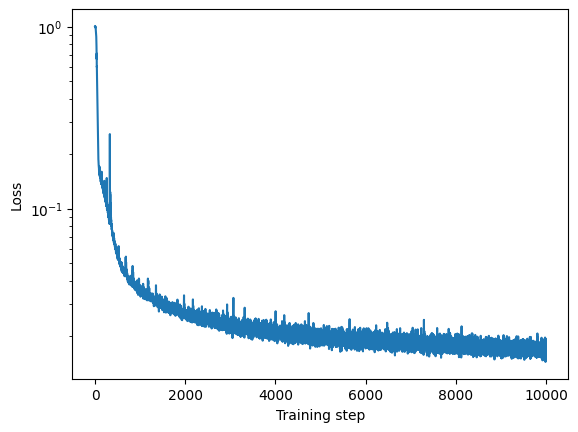

(1, 28, 28) ()
(2, 28, 28)
(32, 14, 14)
(64, 7, 7)
(128, 7, 7)
(64, 14, 14)
(32, 28, 28)
(1, 28, 28)
(1, 28, 28) ()
(2, 28, 28)
(32, 14, 14)
(64, 7, 7)
(128, 7, 7)
(64, 14, 14)
(32, 28, 28)
(1, 28, 28)
(1, 28, 28) ()
(2, 28, 28)
(32, 14, 14)
(64, 7, 7)
(128, 7, 7)
(64, 14, 14)
(32, 28, 28)
(1, 28, 28)


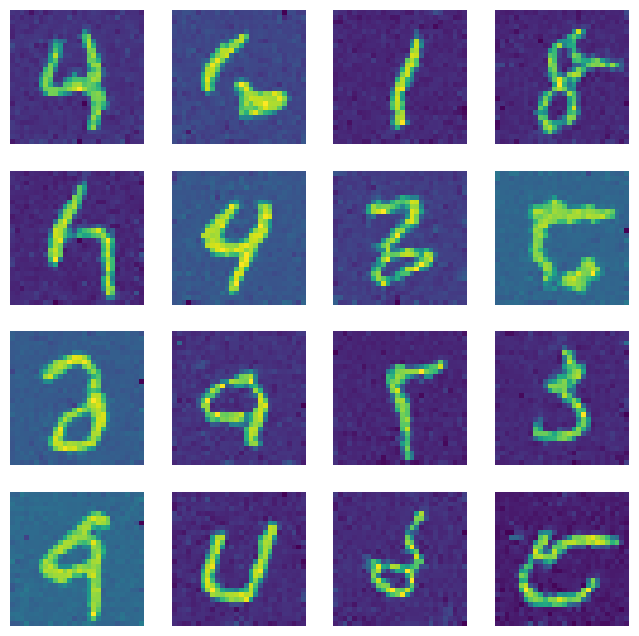

[12000/50000] loss: 0.01496179774403572
[14000/50000] loss: 0.015625596046447754
[16000/50000] loss: 0.014219305478036404
[18000/50000] loss: 0.01350887306034565
[20000/50000] loss: 0.016144312918186188


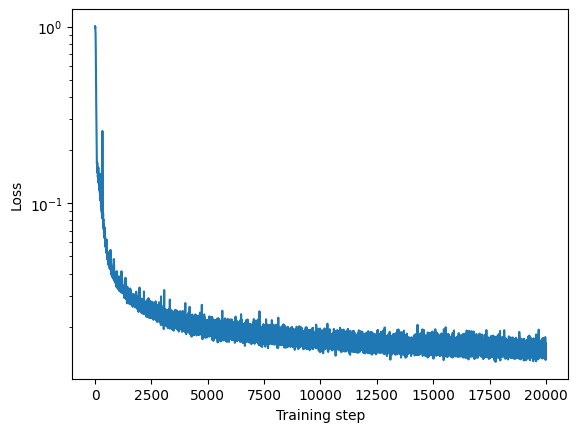

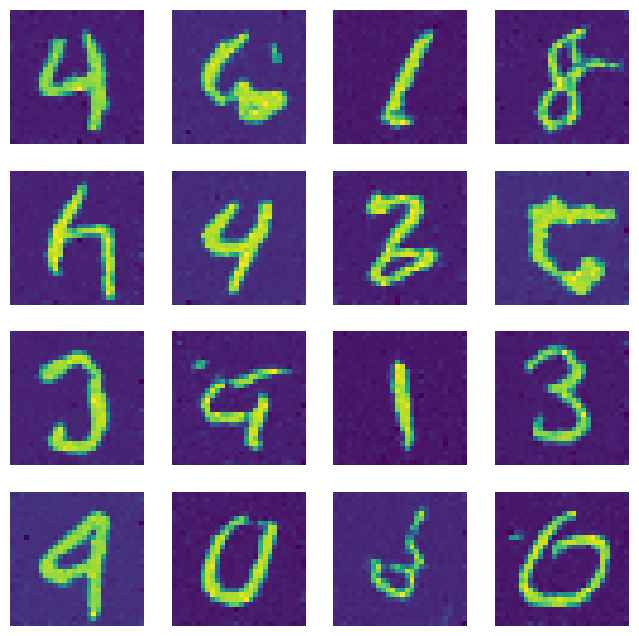

[22000/50000] loss: 0.014386416412889957
[24000/50000] loss: 0.01341855339705944
[26000/50000] loss: 0.014134586788713932
[28000/50000] loss: 0.014195850118994713
[30000/50000] loss: 0.013627661392092705


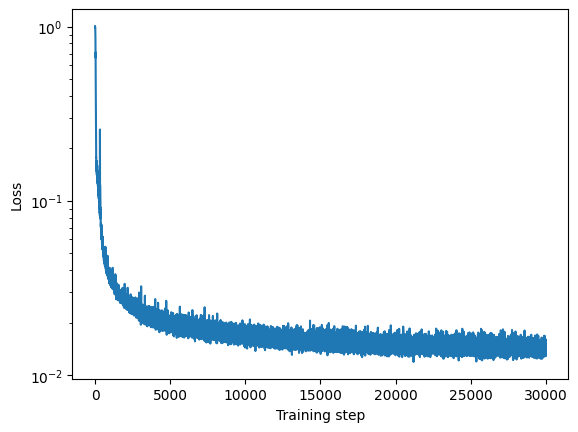

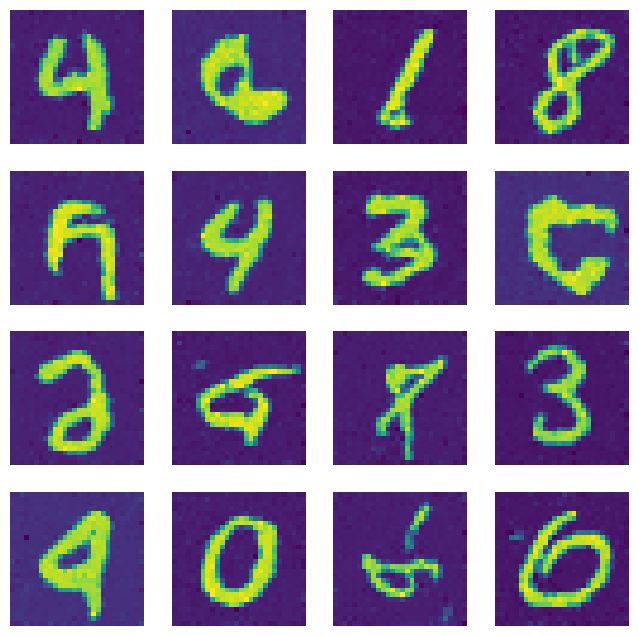

[32000/50000] loss: 0.014863193966448307
[34000/50000] loss: 0.013008792884647846
[36000/50000] loss: 0.013069730252027512
[38000/50000] loss: 0.013136853463947773
[40000/50000] loss: 0.014780987054109573


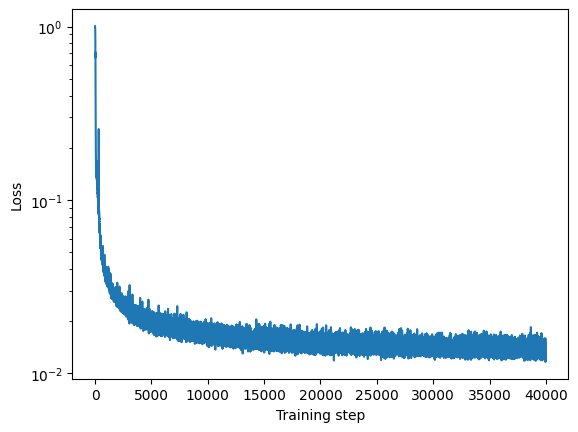

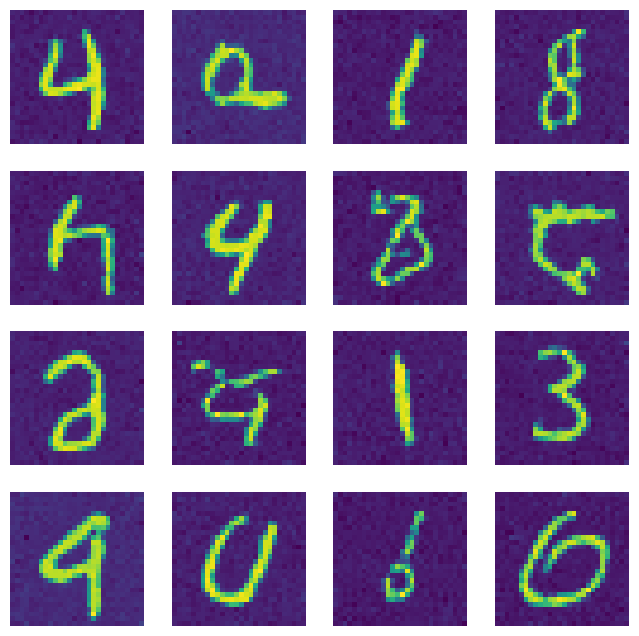

[42000/50000] loss: 0.015021140687167645
[44000/50000] loss: 0.013058017939329147
[46000/50000] loss: 0.012688316404819489
[48000/50000] loss: 0.012449193745851517
[50000/50000] loss: 0.013159219175577164


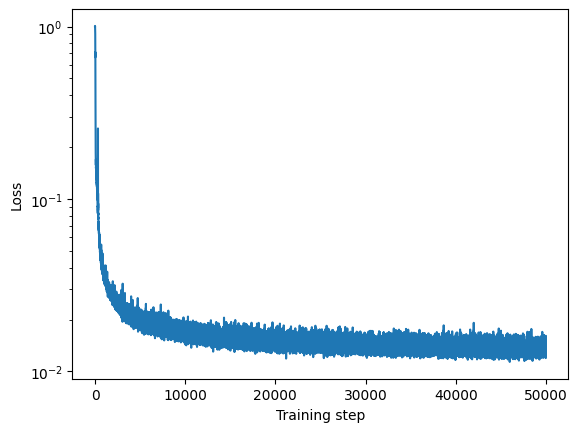

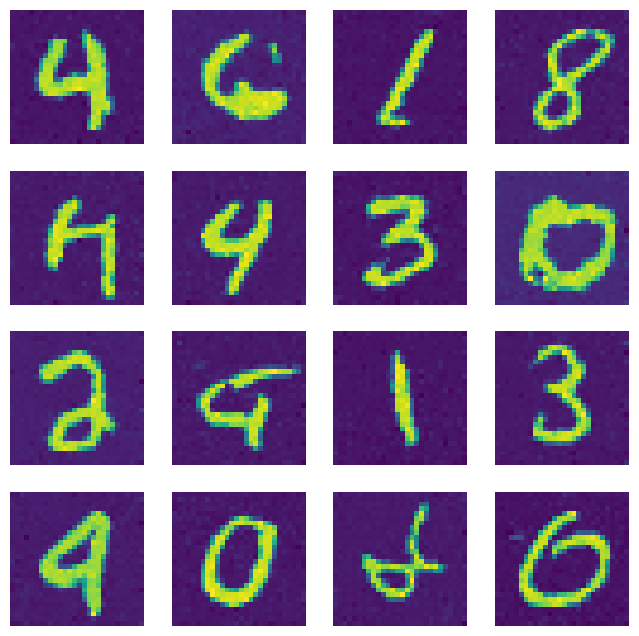

In [19]:
batch_size = 256
n_steps = 50000
key = jax.random.key(0)

# define beta, time range
int_beta = lambda t: t# can experiment with this
t1 = 10

t_ = jnp.linspace(0,t1,1000)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("$p(x_t|x_0)$ mean")
plt.plot(t_, jnp.exp(-0.5 * int_beta(t_)))
plt.subplot(1,2,2)
plt.title("$p(x_t|x_0)$ variance")
plt.plot(t_, 1 - jnp.exp(-int_beta(t_)))
plt.show()

# define model
key, key1, key2 = jax.random.split(key, 3)
#model = CNN(n_hidden_layers=4, hidden_channels=32, kernel_size=5, key=subkey)
model = UNet(in_channels=2, out_channels=1, n_hidden=32, n_levels=2, n_width=2, key=key1)
#print(model)

# define model sampling for test inputs
x_0_shape = data[0].shape
dt0 = 1e-2
keys_test = jr.split(key2, 4*4)

# define optimiser
optimiser = optax.adam(learning_rate=3e-4)
opt_state = optimiser.init(eqx.filter(model, eqx.is_inexact_array))
opt_update = optimiser.update
lossvals = []
for i in range(n_steps):
    
    # sample batch
    key, key1, key2 = jr.split(key, 3)
    x_0_batch = data[jr.randint(key1, (batch_size,), 0, data.shape[0])]
    
    # make update step
    lossval, model, opt_state = make_step(model, int_beta, t1, x_0_batch, opt_state, opt_update, key2)
    lossvals.append(lossval)
    
    # print/plot results
    if (i+1) % 2000 == 0 or i == 0:
        print(f"[{i+1}/{n_steps}] loss: {lossval}")
    if (i+1) % 10000 == 0:
        plt.figure()
        plt.plot(np.array(lossvals))
        plt.yscale("log")
        plt.ylabel("Loss")
        plt.xlabel("Training step")
        plt.show()
        x_0s = jax.vmap(single_sample_fn, in_axes=(None,None,None,None,None,0))(
            model, int_beta, t1, x_0_shape, dt0, keys_test)
        plt.figure(figsize=(8,8))
        for i in range(4*4):
            plt.subplot(4,4,i+1)
            plt.imshow(x_0s[i,0])
            plt.axis("off")
        plt.show()

> Optional extension task: can you improve the performance of the model, e.g. by changing the network architecture, or the underlying SDE?